In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator, FuncFormatter

In [2]:
sns.set(rc={'figure.figsize':(14, 7)})
sns.set_style("whitegrid")

In [3]:
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "sans-serif",
#     "font.sans-serif": ["Helvetica"]})

# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

In [36]:
def plot(df, omega, title, alpha=0.5, stylek=False):
    fig, axs = plt.subplots(ncols=2)
    fig.set_size_inches(18, 8)
    
    dfx = df[df["omega"] == omega]
    if stylek:
        g1 = sns.scatterplot(x="num_kmers", y="time", hue="alg", style="k", data=dfx, ax=axs[0], alpha=alpha, palette=palette)
        g2 = sns.scatterplot(x="num_kmers", y="time", hue="alg", style="k", data=dfx, ax=axs[1], alpha=alpha, palette=palette)
    else:
        g1 = sns.scatterplot(x="num_kmers", y="time", hue="alg", data=dfx, ax=axs[0], alpha=alpha, palette=palette)
        g2 = sns.scatterplot(x="num_kmers", y="time", hue="alg", data=dfx, ax=axs[1], alpha=alpha, palette=palette)
    g2.set_yscale("log")
    g2.set_xscale("log")
    
    
    fig.suptitle(title)
    xlabel = "Num of k-mers"
    ylabel = "Time to process a window, microseconds"
    axs[0].set_xlabel(xlabel)
    axs[0].set_ylabel(ylabel)
    axs[1].set_xlabel(xlabel)
    axs[1].set_ylabel(ylabel)
    
    #return fig

In [5]:
palette = sns.color_palette("Set2", 2)
palette

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961)]

In [7]:
# Average time per window of size Zbase (+- delta%) for different k
def plot1(df, Zbase, delta, ax, **kwargs):
    title = kwargs.get("title", "")
    legend = kwargs.get("legend", False)
    ylabel = kwargs.get("ylabel", False)
    
    Delta = Zbase / 100 * delta
    dfb = df[df["num_kmers"].between(Zbase - Delta, Zbase + Delta)]
    
    g = sns.lineplot(data=dfb, x="k", y="time", hue="alg", marker='o', palette=palette, ax=ax, legend=legend)
    g.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    g.set_yscale("log")
    ytext = "Mean running time per window, microsec" if ylabel else ""
    g.set_ylabel(ytext)
    g.set_title(title)
    if legend:
        leg = g.axes.get_legend()
        leg.set_title("Algorithm")
        tx = leg.texts
        for t in tx:
           t.set_text(t.get_text().upper())
    
    return g
    

In [46]:
def plot1_collection(df, **kwargs):
    z_values = [10, 100, 1000, 10000]
    num_plots = len(z_values)

    sns.set(rc = {'figure.figsize':(5 * num_plots, 5)})
    sns.set_style("whitegrid")

    fig, ax = plt.subplots(1, num_plots)

    for i, z in enumerate(z_values):
        ylabel = (i == 0)
        legend = (i == 0)
        g1 = plot1(df, z, 1, ax[i], ylabel=ylabel, legend=legend, title=r"$|\mathcal{Z}|\approx$" + str(z))

    plt.tight_layout()
    #return fig

In [18]:
def plot2(df, k, ax=None, **kwargs):
    sample_size = kwargs.get("sample_size", 5000)
    all_k = kwargs.get("all_k", False)
    title = kwargs.get("title", "")
    legend = kwargs.get("legend", False)
    ylabel = kwargs.get("ylabel", False)
    logy = kwargs.get("logy", False)
    
    dfk = df if all_k else df[df["k"] == k]
    dfg = dfk.groupby(['num_kmers', 'k', 'omega', 'alg']).mean().reset_index()
    
    max_num_kmers = dfk["num_kmers"].max()
    log_max_num_kmers = np.log10(max_num_kmers)
    
    space = np.linspace(1, max_num_kmers, num=sample_size)
    logspace = np.logspace(1, log_max_num_kmers, num=sample_size)
    
    if logy:
        df_rarefied = dfg[dfg["num_kmers"].isin(logspace)]
    else:
        df_rarefied = dfg[dfg["num_kmers"].isin(space)]

    if ax:
        g = sns.scatterplot(data=df_rarefied, x='num_kmers', y='time', hue='alg', ax=ax, palette=palette, legend=legend)
    else:
        g = sns.scatterplot(data=df_rarefied, x='num_kmers', y='time', hue='alg', palette=palette, legend=legend)
    g.set_xlabel("$|\mathcal{Z}|$")
    
    ytext = "Mean processing time, microsec" if ylabel else ""
    g.set_ylabel(ytext)
    
    if logy:
        g.set_xscale("log")
        g.set_yscale("log")
        
    g.set_title(title)
    
    if legend:
        leg = g.axes.get_legend()
        leg.set_title("Algorithm")
        tx = leg.texts
        for t in tx:
           t.set_text(t.get_text().upper())
    
    return g


In [19]:
def plot2_collection(df, logy=False):
    sns.set(rc = {'figure.figsize':(5, 5)})
    sns.set_style("whitegrid")

    k_values = [6, 8, 10, 12]
    num_plots = len(k_values)

    sns.set(rc = {'figure.figsize':(5 * num_plots, 5)})
    sns.set_style("whitegrid")

    fig, ax = plt.subplots(1, num_plots)

    for i, k in enumerate(k_values):
        ylabel = (i == 0)
        legend = (i == 0)
        g1 = plot2(df, k, ax[i], ylabel=ylabel, legend=legend, title="$k=$" + str(k), sample_size=1000, logy=logy)

    plt.tight_layout()


### Neotrop

Measurements made for 100 random ghost nodes of Neotrop. Nodes are the same for both algorithms. All windows of the alignment are considered for every node. Time measurements: microseconds per window

In [41]:
neotrop = pd.read_csv("results/neotrop-100-o1.5.csv")
neotrop["time"] += 1
neotrop["num_kmers"] += 1
neotrop["k"] = neotrop["k"].astype(int)
neotrop["avg"] = neotrop["time"] / neotrop["num_kmers"]

### D155 (HCV)

100 random ghost nodes

In [42]:
d155 = pd.read_csv("results/d155-random-100-o1.5.csv")
d155["time"] += 1
d155["num_kmers"] += 1

### Random data

Alignment length = 1000

In [43]:
random = pd.read_csv("results/random-100-o1.5.csv")
random["time"] += 1
random["num_kmers"] += 1
random["k"] = random["k"].astype(int)
random["avg"] = random["time"] / random["num_kmers"]

## Plot 1: fix |Z|, vary k. Mean running time

Let's take windows of different length that generate Zconst +- (1% * Zconst) phylo-k-mers. Let's see if time to generate this fixed number of k-mers depends on the length of the window (i.e., k).

This plot can not be done for random data, because there is low variability of sizes of |Z| for every value of k.

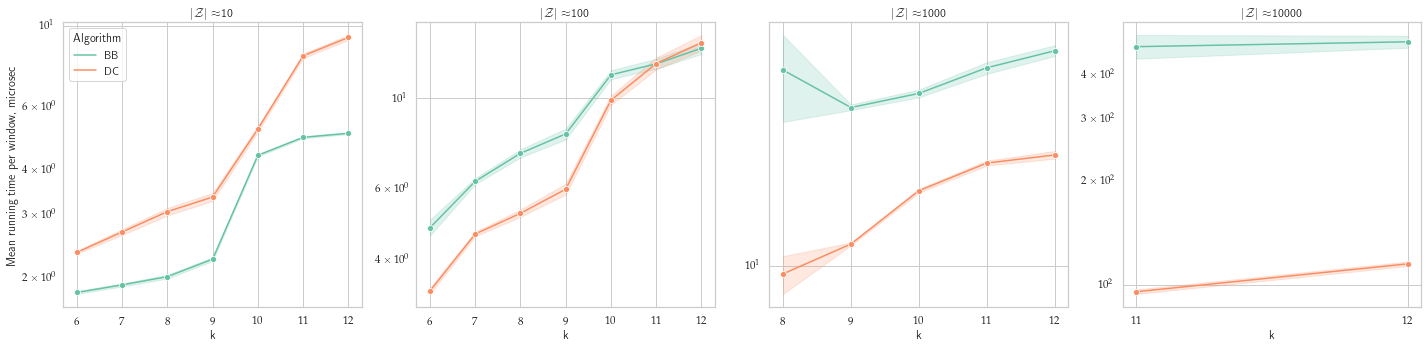

In [47]:
g = plot1_collection(neotrop)

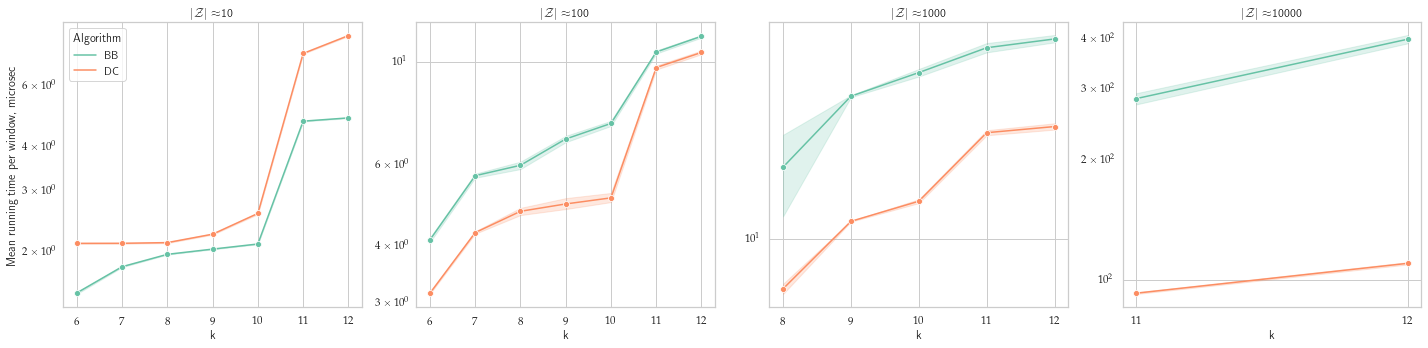

In [48]:
g = plot1_collection(d155)

## Plot 2: fix k, vary |Z|. Mean running time

Let's fix k and see how time depends on the size of |Z|. For one value of |Z| on X-axis, show the mean time of generating such windows.

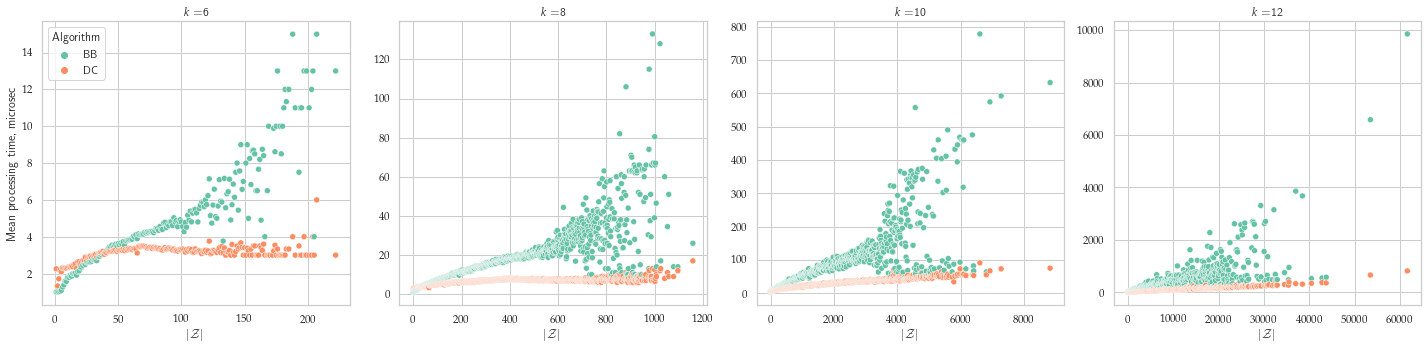

In [49]:
plot2_collection(neotrop, False)

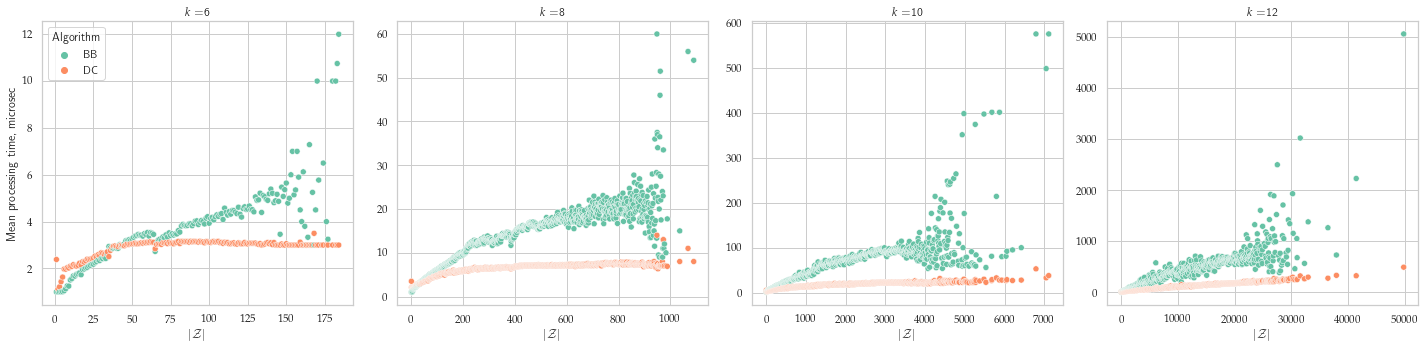

In [50]:
plot2_collection(d155, False)

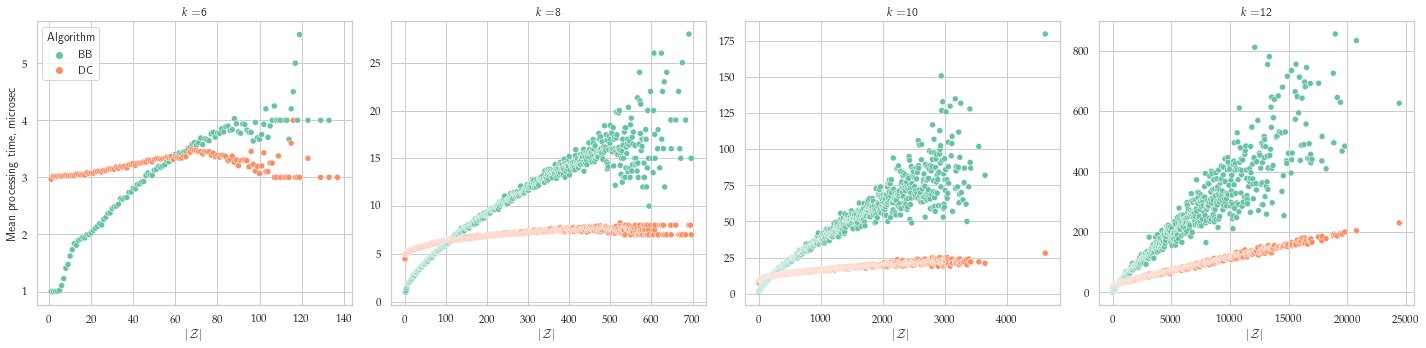

In [51]:
plot3_collection(random, False)

## Plot 2 in log scale

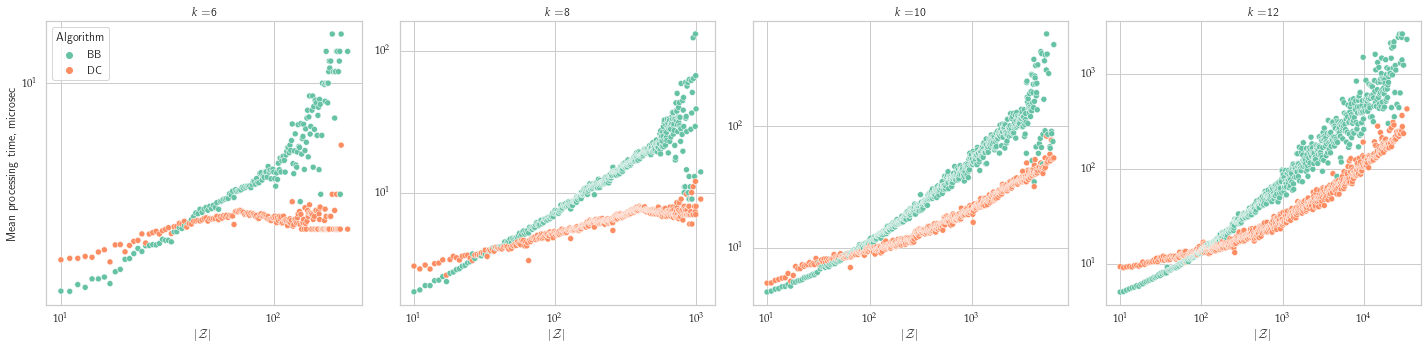

In [52]:
plot2_collection(neotrop, True)

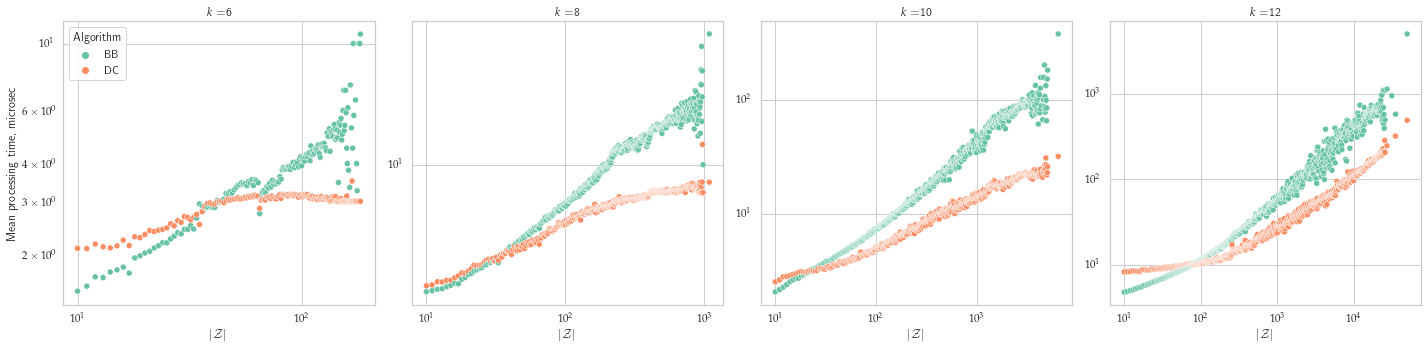

In [53]:
plot2_collection(d155, True)

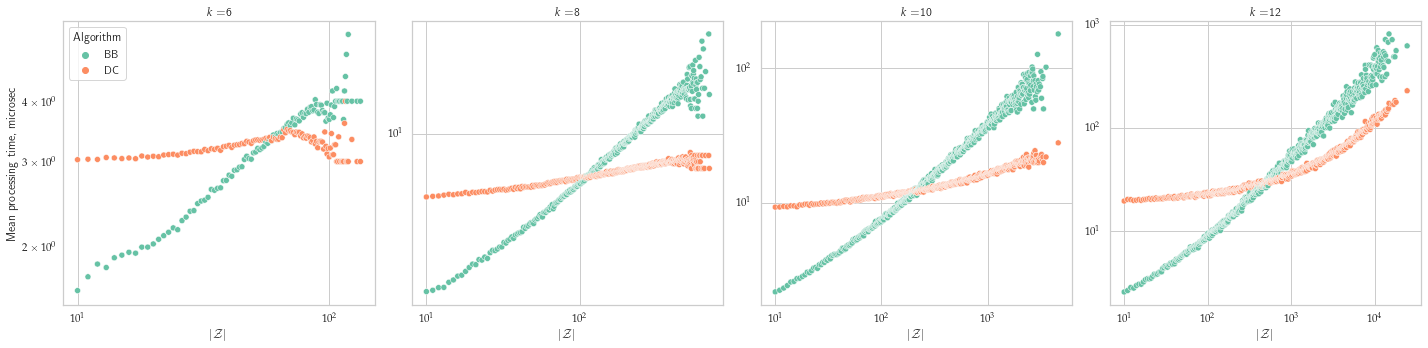

In [54]:
plot3_collection(random, True)

## Plot2.1: vary |Z|, but show mean time grouped by k

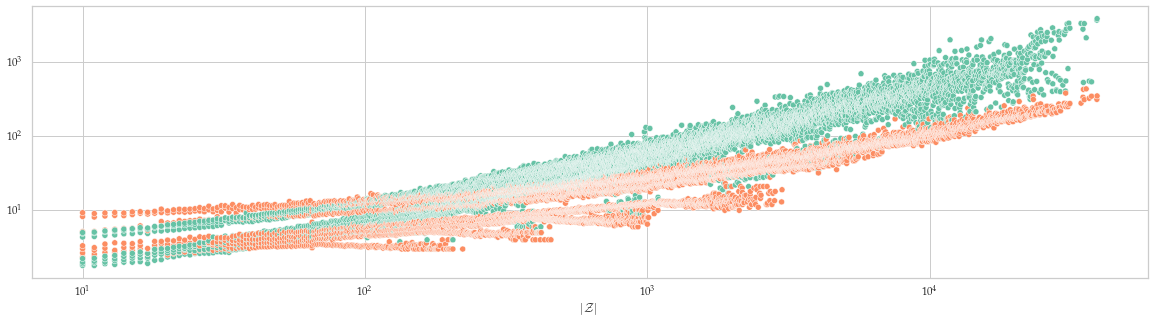

In [15]:
plot2(neotrop, 0, all_k=True, sample_size=5000, logy=True)

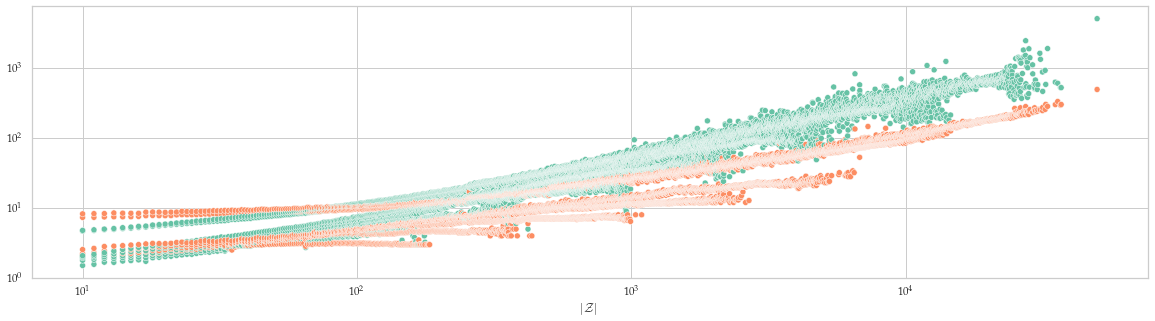

In [55]:
plot2(d155, 0, all_k=True, sample_size=5000, logy=True)

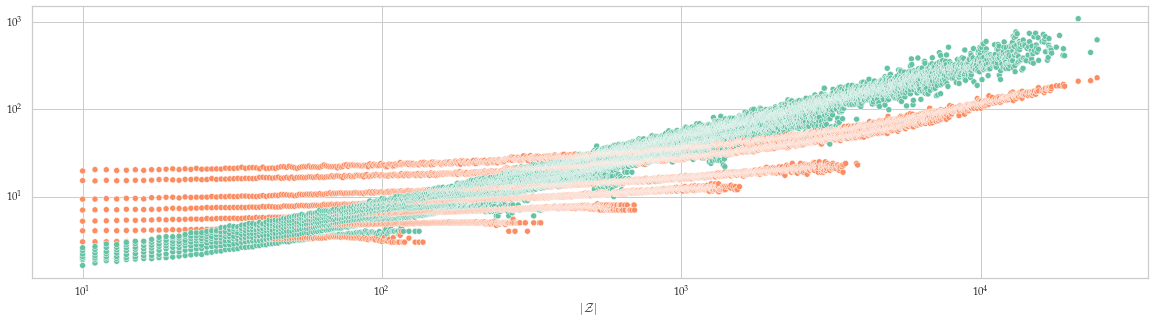

In [56]:
plot2(random, 0, all_k=True, sample_size=5000, logy=True)

# Plot 3: |Z| vs. running time all together

In [ ]:
#plot(neotrop, 1.5, "Neotrop")

In [60]:
#plot(d155, 1.5, "D155")

In [61]:
#plot(random, 1.5, "Random")